# DQNを構築する

In [2]:
import gym
import math
import random
import math
import copy
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import settings

In [3]:
%load_ext autoreload
%autoreload 2

## ゲーム環境を構築

In [4]:
def get_screen(env, resize):
    
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height * 0.4): int(screen_height * 0.8)]
    
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(env=env, screen_width=screen_width)
    
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)

    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)

    return resize(screen).unsqueeze(0)

In [5]:
def get_cart_location(env, screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

In [6]:
resize = T.Compose([
    T.ToPILImage(),
    T.Resize(40, interpolation=Image.CUBIC),
    T.ToTensor()
])

/usr/local/lib/python3.9/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [7]:
env = gym.make('CartPole-v0').unwrapped

In [8]:
env.reset()
screen = get_screen(env=env, resize=resize)

In [9]:
env.reset()
init_screen = get_screen(env=env, resize=resize)
_, _, screen_height, screen_width = init_screen.shape
n_action = env.action_space.n
print(f'スクリーン: 幅 {screen_width} × 高さ {screen_height}')
print(f'アクション数: {n_action}')

スクリーン: 幅 90 × 高さ 40
アクション数: 2


## DQNのモデルを構築する

In [10]:
class DQN(nn.Module):
    
    def __init__(self, h, w, output_dim):
        
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        convw = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(w)))
        convh = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, output_dim)
        
    def forward(self, x):
        x = x.to(settings.device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
    
    def conv2d_size_out(self, size, kernel_size=5, stride=2):
        return (size - (kernel_size - 1) - 1) // stride + 1

In [11]:
class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, Transition, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [24]:
def select_action(policy_net, state, n_action, steps_done):
    threshold = settings.EPS_END + (settings.EPS_START - settings.EPS_END) * math.exp(-1. * steps_done / settings.EPS_DECAY)
    if random.random() > threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_action)]], device=settings.device, dtype=torch.long)

## DQNの学習

In [13]:
def make_train_and_valid_data(memory, Transition):
    
    transitions = memory.sample(settings.BATCH_SIZE_TRAIN + settings.BATCH_SIZE_VALID)
    indexes = list(range(settings.BATCH_SIZE_TRAIN + settings.BATCH_SIZE_VALID))
    random.shuffle(indexes)
    transitions_train = [transitions[i] for i in indexes[:settings.BATCH_SIZE_TRAIN]]
    transitions_valid = [transitions[i] for i in indexes[settings.BATCH_SIZE_TRAIN:]]
    batch_train = Transition(*zip(*transitions_train))
    batch_valid = Transition(*zip(*transitions_valid))

    return batch_train, batch_valid

In [18]:
def train_model(policy_net, target_net, batch, Transition, criterion):

    policy_net.train()

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=settings.device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(settings.BATCH_SIZE_TRAIN, device=settings.device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * settings.GAMMA) + reward_batch

    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss

In [19]:
def valid_model(policy_net, target_net, batch, Transition, criterion):

    policy_net.eval()
    with torch.no_grad():

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=settings.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(settings.BATCH_SIZE_VALID, device=settings.device)
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * settings.GAMMA) + reward_batch

        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    return loss

In [74]:
policy_net = DQN(h=screen_height, w=screen_width, output_dim=n_action).to(settings.device)
target_net = DQN(h=screen_height, w=screen_width, output_dim=n_action).to(settings.device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

memory = ReplayMemory(50000)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(policy_net.parameters())
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
steps_done = 0
best_net = None
best_loop = 0
counter = 1
results = []

for i_episode in range(settings.EPOCHS):

    env.reset()
    last_screen = get_screen(env=env, resize=resize)
    current_screen = get_screen(env=env, resize=resize)
    state = current_screen - last_screen
    
    for t in count():
        
        start_time = time.time()
        # DQNを使ったアクションの選択
        action = select_action(
            policy_net=policy_net, state=state, n_action=n_action, steps_done=steps_done
        )
        
        # 選択されたアクションで状態遷移し、報酬を得る
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=settings.device)
        
        # 状態遷移後の画像差分を計算
        last_screen = current_screen
        current_screen = get_screen(env=env, resize=resize)
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(Transition, state, action, next_state, reward)

        state = next_state
        
        if done:
            break

    steps_done += 1

    if len(memory) >= settings.BATCH_SIZE_TRAIN + settings.BATCH_SIZE_VALID:
        batch_train, batch_valid = make_train_and_valid_data(memory=memory, Transition=Transition)

        loss_train = train_model(
            policy_net=policy_net, target_net=target_net, batch=batch_train,
            Transition=Transition, criterion=criterion
        )
        loss_valid = train_model(
            policy_net=policy_net, target_net=target_net, batch=batch_valid,
            Transition=Transition, criterion=criterion
        )
        elapsed_time = time.time() - start_time
        print('[{}/{} max loop: {}] train loss: {:.4f}, valid loss: {:.4f} [{}{:.0f}s] {}{}'.format(
            i_episode, settings.EPOCHS, t,
            loss_train, loss_valid,
            str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
            elapsed_time % 60,
            counter,
            ' **' if t > best_loop else ''
        ))

        results.append([i_episode, t, loss_train.item(), loss_valid.item()])
            
    
    if t > best_loop:
        best_net = copy.deepcopy(policy_net)
        best_loop = t
        target_net.load_state_dict(policy_net.state_dict())
        counter = 1
    else:
        counter += 1
        if counter > 100:
            target_net.load_state_dict(policy_net.state_dict())
            counter = 1
            
results = pd.DataFrame(results, columns=['i_episode', 'max_loop', 'loss_train', 'loss_valid'])
print('Complete')
env.render()
env.close()

[8/1000 max loop: 20] train loss: 0.7955, valid loss: 0.2649 [0s] 7
[9/1000 max loop: 15] train loss: 0.2016, valid loss: 0.2194 [0s] 8
[10/1000 max loop: 44] train loss: 0.1466, valid loss: 0.0904 [0s] 9
[11/1000 max loop: 23] train loss: 0.0557, valid loss: 0.0459 [0s] 10
[12/1000 max loop: 30] train loss: 0.0536, valid loss: 0.0379 [0s] 11
[13/1000 max loop: 23] train loss: 0.0221, valid loss: 0.0156 [0s] 12
[14/1000 max loop: 34] train loss: 0.0132, valid loss: 0.0088 [0s] 13
[15/1000 max loop: 22] train loss: 0.0093, valid loss: 0.0125 [0s] 14
[16/1000 max loop: 18] train loss: 0.0078, valid loss: 0.0134 [0s] 15
[17/1000 max loop: 53] train loss: 0.0146, valid loss: 0.0100 [0s] 16 **
[18/1000 max loop: 9] train loss: 0.8517, valid loss: 0.6756 [0s] 1
[19/1000 max loop: 19] train loss: 0.5741, valid loss: 0.4344 [0s] 2
[20/1000 max loop: 40] train loss: 0.3713, valid loss: 0.2249 [0s] 3
[21/1000 max loop: 15] train loss: 0.2336, valid loss: 0.1607 [0s] 4
[22/1000 max loop: 12] trai

## 学習結果を可視化する

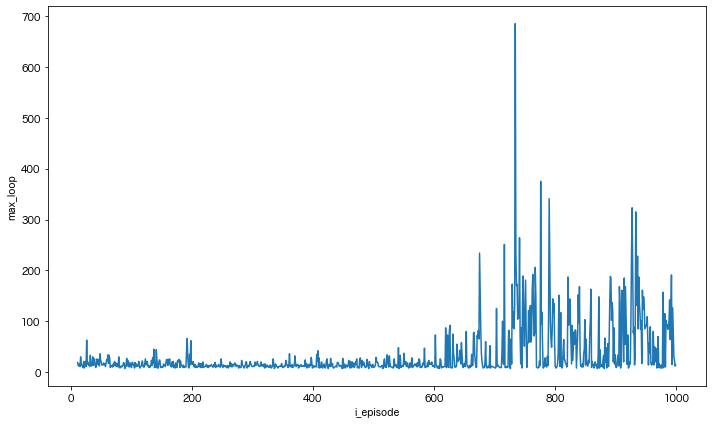

In [32]:
plt.figure(figsize=(10, 6), facecolor='white')
sns.lineplot(
    data=results,
    x='i_episode',
    y='max_loop'
)
plt.tight_layout()
plt.savefig('dqn_max_loop.png', dpi=300)

## 学習したモデルを使ってゲーム

In [65]:
time.sleep(3)
env.reset()
last_screen = get_screen(env=env, resize=resize)
current_screen = get_screen(env=env, resize=resize)
state = current_screen - last_screen

for t in count():

    action = best_net(state).max(1)[1].view(1, 1)

    _, reward, done, _ = env.step(action.item())

    # 状態遷移後の画像差分を計算
    last_screen = current_screen
    current_screen = get_screen(env=env, resize=resize)
    if not done:
        next_state = current_screen - last_screen
    else:
        next_state = None

    state = next_state
    if done:
        break
        
print(f'試行回数: {t}')

試行回数: 145
